# **Article Results - Accelerometer Dataset**

The dataset analyzed ("Acc.xlsx") in this notebook is the same as presented in article "**An Unsupervised TinyML Approach Applied for Pavement Anomalies Detection Under the Internet of Intelligent Vehicles**" by the same authors. In the referenced [article](https://ieeexplore.ieee.org/document/9488546), the TEDA algorithm was implemented on an [Arduino Nano 33 IoT](https://store.arduino.cc/products/arduino-nano-33-iot) Platform for the purpose of detecting anomalies in pavements using the accelerometer signal from the Arduino. In the current article, we again applied TEDA, using Python, to the same dataset and, of course, found similar results. However, we went further and also applied the *TEDA RLS* algorithm to correct the identified outliers.

- Dataset from: 
*P. Andrade* et al., "**An Unsupervised TinyML Approach Applied for Pavement Anomalies Detection Under the Internet of Intelligent Vehicles**," 2021 IEEE International Workshop on Metrology for Industry 4.0 & IoT (MetroInd4.0&IoT), Rome, Italy, 2021, pp. 642-647, doi: 10.1109/MetroInd4.0IoT51437.2021.9488546.

## 1. Modules import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


#### Importing our modules:

In [2]:
from teda import TEDA
from RLSFilter import RLSFilter

## 2. Data import

### 2.1 Arduino data:
Here, we will import accelerometer data where the "$A$" column represents the total acceleration, and $Ax$, $Ay$, and $Az$ represent the 3-axis accelerations. The total acceleration ($A$) is calculated as follows:

\begin{align}
A = \sqrt{{A_x}^2 + {A_y}^2 + {A_z}^2}
\end{align}

In [3]:
data_acc = pd.read_excel("Acc.xlsx", index_col=0)
data_acc.head()

,Latitude,Longitude,Gx,Gy,Gz,Data,Hora,Ax,Ay,Az,A,Flag,Label
Device Time,,,,,,,,,,,,,
12-Feb-2021 14:21:33.764,-5.831842,-35.205239,0.479096,5.731182,7.763746,12/02/2021,14:20:44,-0.36,0.18,0.88,0.97,0,0
12-Feb-2021 14:21:34.761,-5.831842,-35.205239,0.415616,4.307071,8.708762,12/02/2021,14:20:45,-0.33,0.27,0.85,0.95,0,0
12-Feb-2021 14:21:35.761,-5.831842,-35.205239,-0.213198,4.725081,8.572220,12/02/2021,14:20:46,-0.30,0.26,0.90,0.98,0,0
12-Feb-2021 14:21:36.766,-5.831842,-35.205239,-2.579930,1.064790,10.250253,12/02/2021,14:20:47,-0.25,0.26,0.92,0.99,0,0
12-Feb-2021 14:21:37.763,-5.831842,-35.205239,0.527005,-2.172699,8.755474,12/02/2021,14:20:48,-0.13,0.34,0.92,0.99,0,0


## 3. Running on Python:

### Defining algorithm instances:

In [4]:
#TEDA
teda = TEDA(threshold=2.3)
FLAG = []

#RLS
filter_order = 2                    #filter_order equivalent to window size
forgetting_factor = 0.99            #Forgetting factor: It is introduced to give exponentially less weight to older error samples. It is usually chosen between 0.98 and 1.
regularization_factor = 0.1         #It is usually chose between 0.1 and 1.
w0 = [0.0, 0.0]                     #Initial weights
X_ant = [0.0, 0.0]                  #Initial previous input
rls_filter = RLSFilter(n = filter_order, mu = forgetting_factor, delta=regularization_factor, w=w0) #Defining the filter instance
y_pred_py = 0.0                     #Initial predicted value

#### Defining auxiliary variables:

In [5]:
Ya_py = []
Y_py = []
DB = []
outlier_count = 0
N_outlier_max = 2

### Running:

In [6]:
for A in data_acc['A']:
    ## Acquiring the data input
    valor_atual = A

    #Checking if it is an outlier
    flag = teda.run(valor_atual)
    FLAG.append(flag)

    ## Correcting outlier
    if (flag == 1):
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0
    
    #Evaluating the flood of outliers
    if(outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = A
    #Saving 
    Ya_py.append(y_pred_py)

    # Updating weights
    rls_filter.update(valor_atual, np.array(X_ant))
    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    #Predicting the next value
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    # Second stage
    if (flag == 1):
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0
    if(outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = A
    DB.append(valor_atual)

    #Updating previous values vector
    X_ant = input_vector

data_acc['flag_py'] = FLAG
data_acc['save_py'] = DB
data_acc['ya_pred_py'] = Ya_py
data_acc['y_pred_py'] = Y_py

## 4. Visualization:

### 4.1 TEDA

In [7]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

In [8]:
numberOfOutliersPython = data_acc['flag_py'].sum()
numberOfOutliersPython

9

In [9]:
outliersIndexPython = find_indices(data_acc['flag_py'], 1)
outliersIndexPython

[15, 49, 86, 193, 198, 217, 242, 282, 306]

#### Time stamp in minutes:

In [10]:
ts = np.linspace(0, len(data_acc)/60, len(data_acc))

### TEDA Chart

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


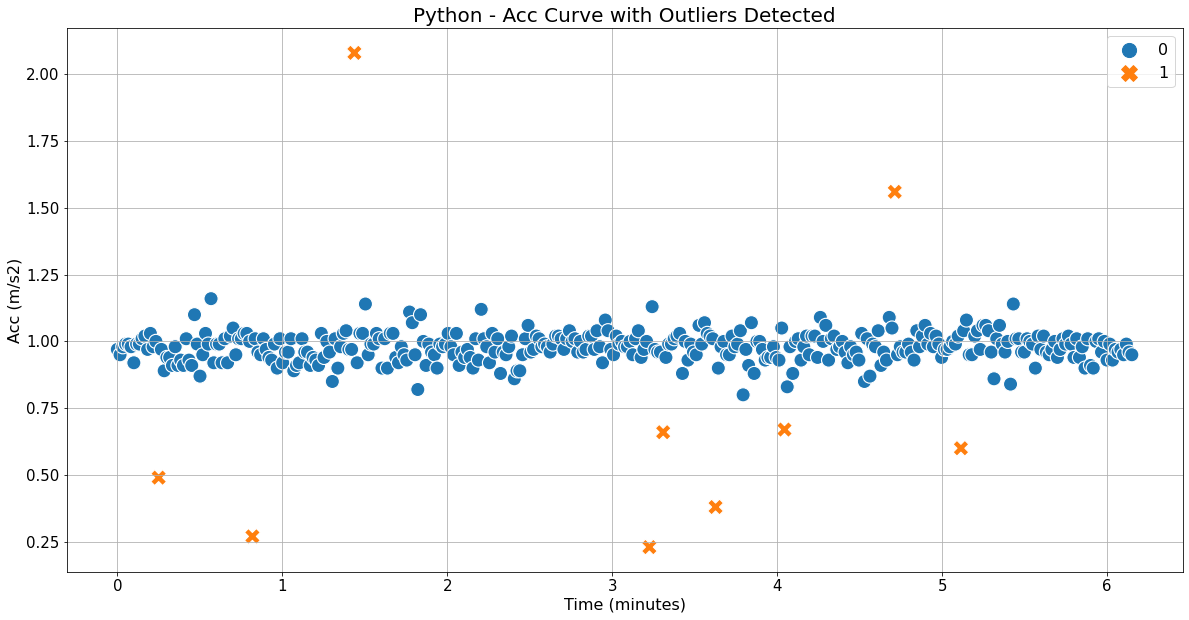

In [11]:
plt.figure(figsize=(20,10))
plt.grid()
plt.title("Python - Acc Curve with Outliers Detected", fontsize=20)
sns.scatterplot(x=ts, y=data_acc['A'], hue=data_acc['flag_py'], style=data_acc['flag_py'], size=data_acc['flag_py'], sizes=(250, 200))
plt.legend(fontsize=16)
plt.ylabel("Acc (m/s2)", fontsize=16)
plt.xlabel("Time (minutes)", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.show()

plt.savefig("C:/Users/Samsung/Desktop/Pedro/UFRN/Portfolio/Publicados/TEDA RLS/Python/figures/Acc/results_acc_curves_teda.eps", dpi=600, bbox_inches='tight')

### 4.2 RLS

In [12]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Accelerometer Dataset"
)

figure.add_trace(
    go.Scatter(x=ts, y=data_acc['A'], name='True'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(x=ts, y=data_acc['y_pred_py'], name='Predicted'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(x=ts, y=data_acc['save_py'], name='Saved'),
    secondary_y=False
)


figure.update_xaxes(title='Time (s)')
figure.update_yaxes(title='A (m/s2)', secondary_y=False)
figure.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


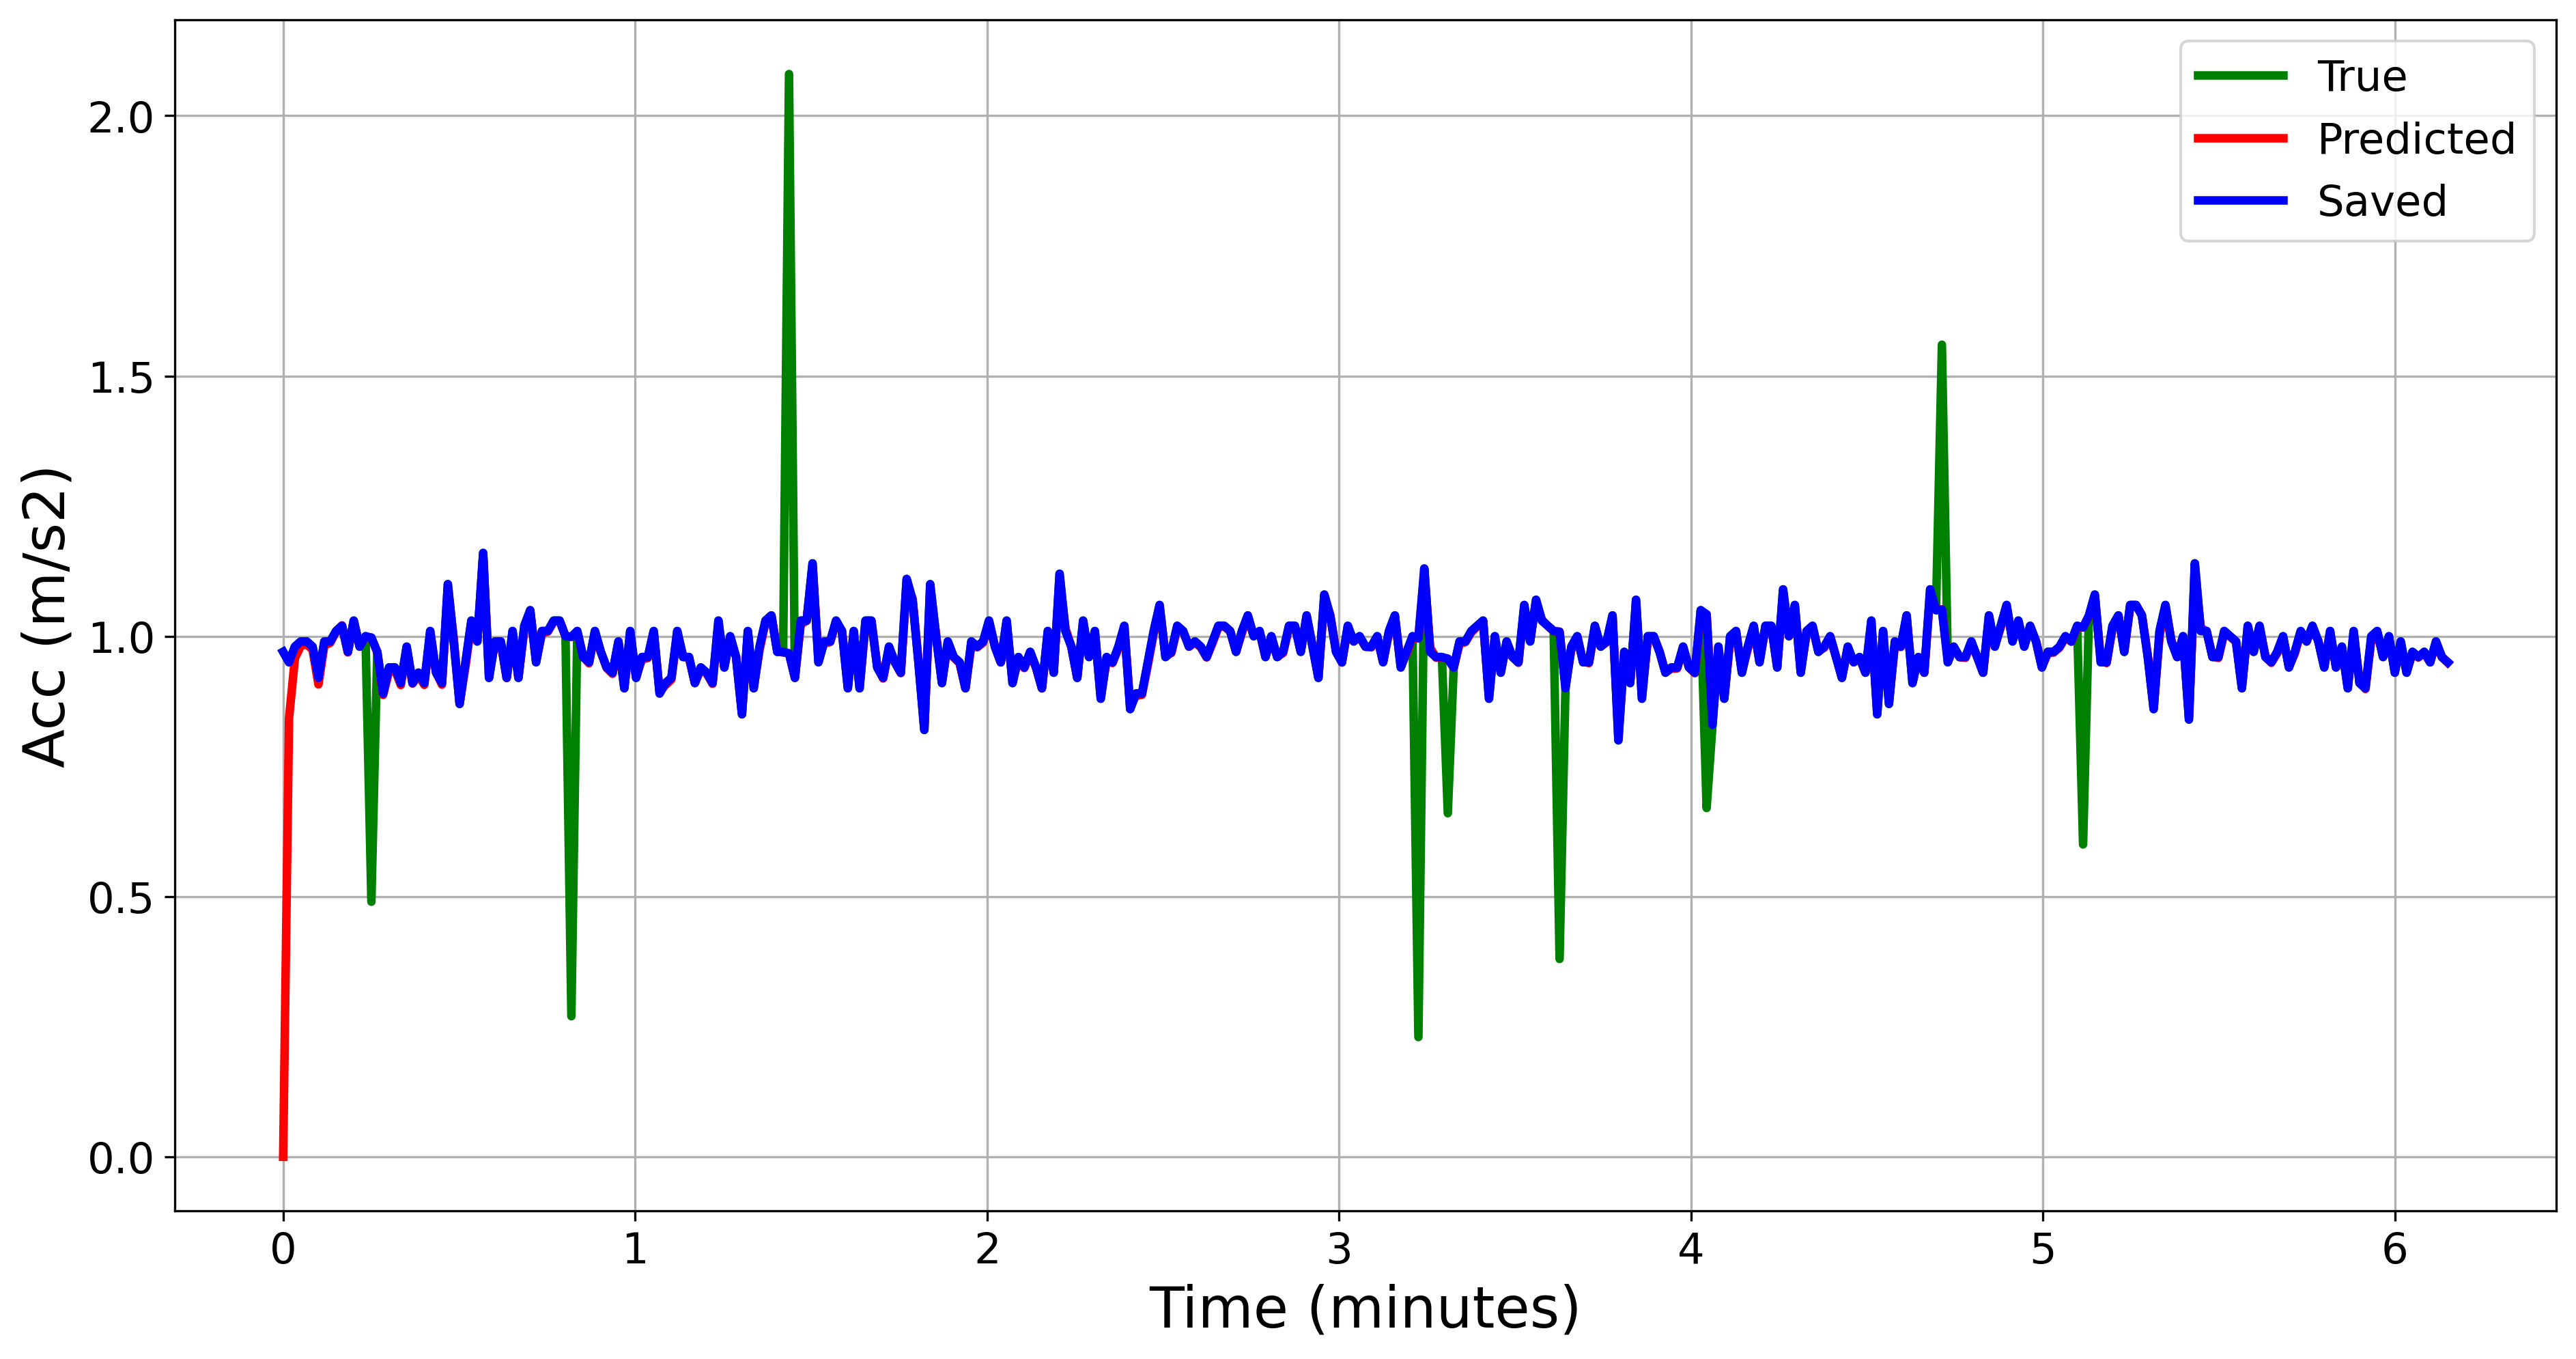

In [13]:
plt.figure(figsize=(15,7.7), dpi=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.xlabel("Time (minutes)", fontsize=20)
plt.ylabel("Acc (m/s2)", fontsize=20)
plt.plot(ts, data_acc['A'], 'g', label='True', linewidth=3)
plt.plot(ts, data_acc['y_pred_py'], 'r', label='Predicted', linewidth=3)
plt.plot(ts, data_acc['save_py'], 'b', label='Saved', linewidth=3)
plt.legend(fontsize=15)

plt.savefig("C:/Users/Samsung/Desktop/Pedro/UFRN/Portfolio/Publicados/TEDA RLS/Python/figures/Acc/results_acc_curves.eps", dpi=600, bbox_inches='tight')

# 5. Metrics

In this section, we will present the metrics for the TEDA classification algorithm, including the **classification report** and **confusion_matrix**, as well as for the RLS forecasting algorithm, which includes the **Mean Squared Error** (MSE) and **Mean Absolute Error** (MAE).

### 5.1 TEDA Evaluation

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

#### 5.1.1 Confusion matrix:

$$
CM = \begin{bmatrix}
TN & FP\\ 
FN & TP
\end{bmatrix}
$$

In [15]:
print(confusion_matrix(data_acc['Label'], data_acc['flag_py']))

[[356   0]
 [  4   9]]


#### 5.1.2 Classification report:

In [16]:
print(classification_report(data_acc['Label'], data_acc['flag_py']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       356
           1       1.00      0.69      0.82        13

    accuracy                           0.99       369
   macro avg       0.99      0.85      0.91       369
weighted avg       0.99      0.99      0.99       369



### 5.2 RLS Evaluation
The MSE metric will be applied between the current values and the values corrected/saved by the algorithm, as well as between the current values and the values predicted by the RLS algorithm.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### 5.2.1 Comparing to Saved Values

In [18]:
start = 0

Root Mean Squared Error (RMSE)

In [20]:
rmse_saved = mean_squared_error(data_acc['A'].iloc[start:], data_acc['save_py'].iloc[start:], squared=False)
rmse_saved

0.09970620763136405

Mean Absolute Error (MAE)

In [21]:
mae_saved = mean_absolute_error(data_acc['A'].iloc[start:], data_acc['save_py'].iloc[start:])
mae_saved

0.014466733049069435

#### 5.2.2 Comparing to Predicted Values

Root Mean Squared Error (MSE) 

In [23]:
rmse_pred = mean_squared_error(data_acc['A'].iloc[start:], data_acc['y_pred_py'].iloc[start:], squared=False)
rmse_pred

0.11199596069760487

Mean Absolute Error (MAE)

In [24]:
mae_pred = mean_absolute_error(data_acc['A'].iloc[start:], data_acc['y_pred_py'].iloc[start:])
mae_pred

0.020768129483440097

# 6. References

 [[1]](https://www.mdpi.com/1424-8220/22/10/3838) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. *A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions*. SENSORS 2022, 22, 3838.  ![GitHub](https://img.shields.io/badge/DOI-10.3390%2Fs22103838-green)


[[2]](https://dl.acm.org/journal/tecs) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Costa, D.G. Soares, E.; _Online Processing of Vehicular Data on the Edge Through an Unsupervised TinyML Regression Technique_. ACM TECS 2023. ![GitHub](https://img.shields.io/badge/DOI-10.1145%2Fs3591356-green)